# Problème n°2: PointNet

Certains jeux de données impliquent des nuages de points dans un espace 3D. Penser par exemple à un ensemble de mesures lidar : chaque tir permet de renseigner les coordonnées d'un des points de l'objet ciblé.
Une tâche intéressante consiste à classer chacun des points du nuage en fonction de l'objet auquel il appartient. Cette tâche est considérée comme une variante de la segmentation sémantique d'images.

Ce problème introduit à une méthode directe de segmentation d'un nuage par deep learning. Elle est basée sur une architecture particulière appelée PointNet. \
Dans la première partie, on présente un jeu de données (synthétisé à la volée) impliquant des nuages de points.
Dans la seconde partie, on explore la structure et les propriétés de PointNet. Dans la troisième, on l'entraîne et dans la dernière partie, on charge les poids d'une version améliorée de PointNet (PointNet++) pour comparaison.

La cellule suivante permet les imports nécessaires:

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import matplotlib.pyplot as plt
import os
! pip install einops
! git clone https://github.com/nanopiero/exam_2025.git
! cp exam_2025/utils/utils_probleme2.py .
from utils_probleme2 import gen_pointcloud, plot_triplets

## Partie I : un exemple de PointCLoud data

Pour construire le jeu de données, on simule un terrain couvert de deux types de bâtiments : des immeubles de forme rectangulaire aux toits plats et des igloos (dômes). Pour créer les nuages, on échantillonne les surfaces vues du ciel (les murs des bâtiments rectangulaires ne sont pas échantillonnées), en favorisant les zones d'altitude non nulles.
Le but est de distinguer les igloos du reste (sol et toits des bâtiments). Il s'agit donc d'une segmentation binaire.

0


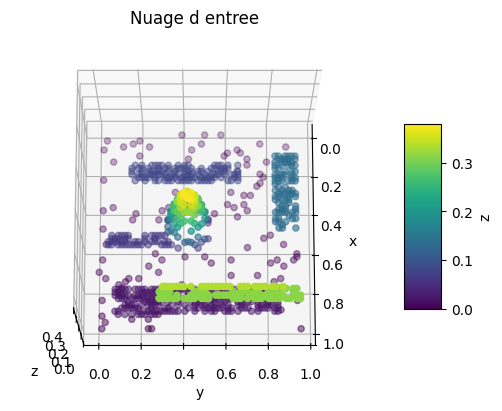

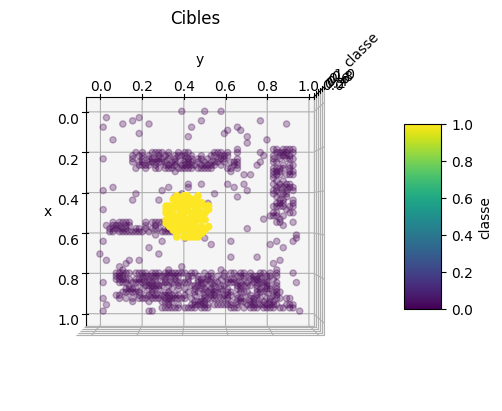

1


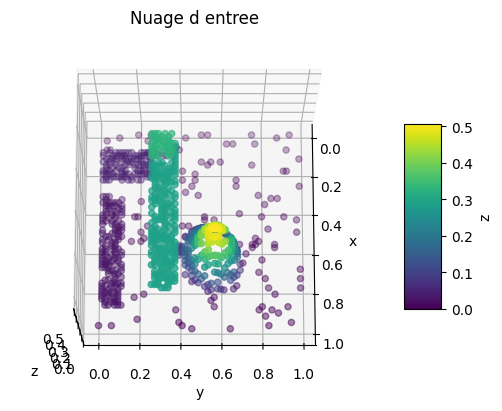

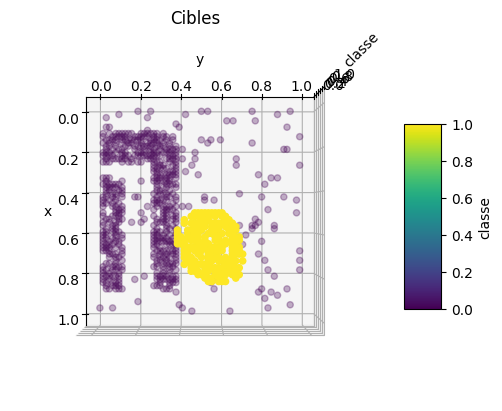

2


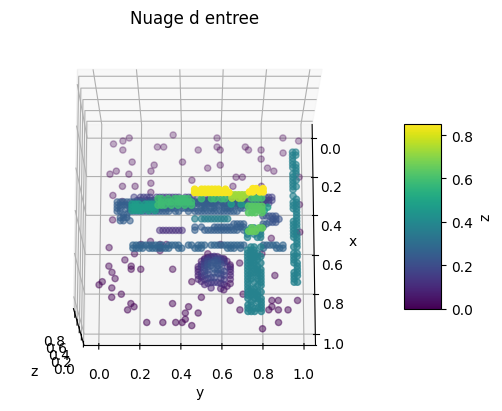

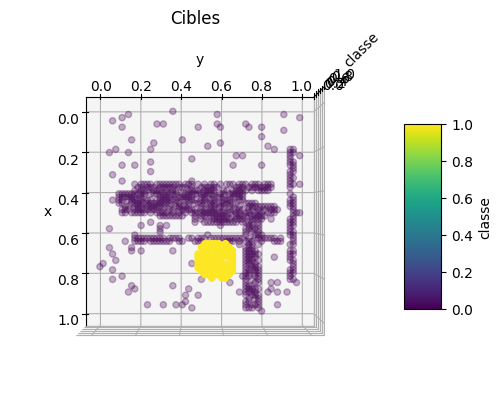

3


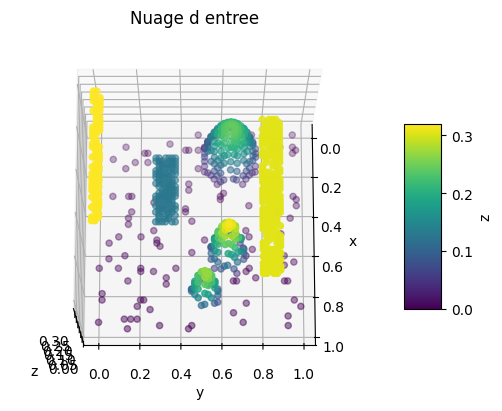

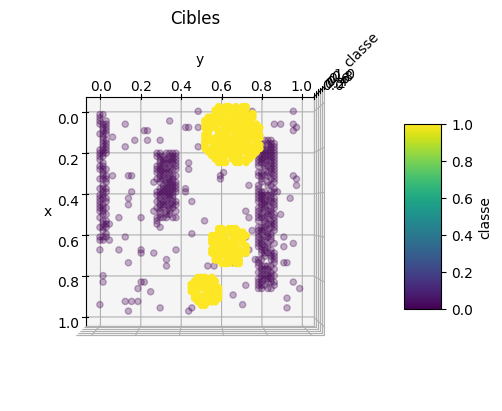

4


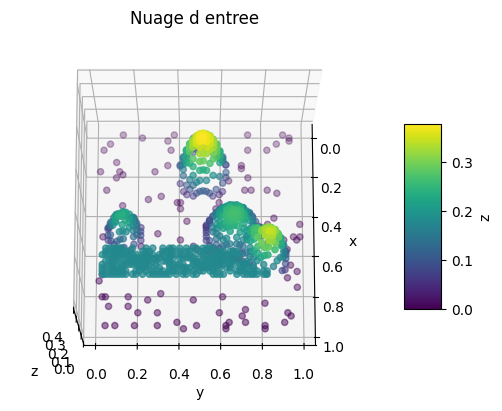

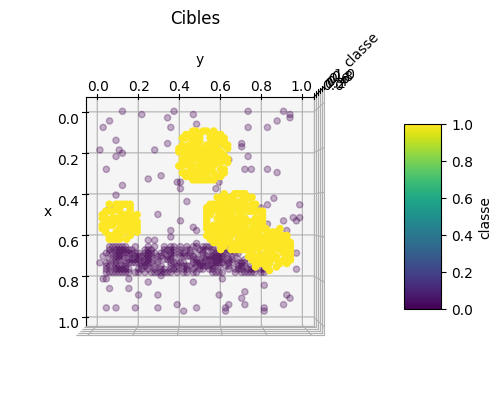

5


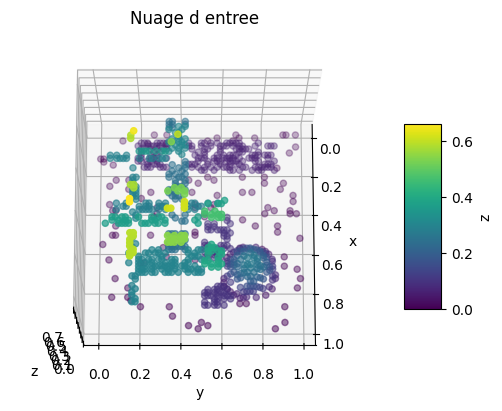

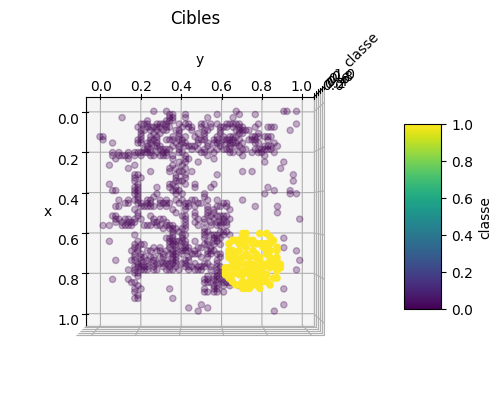

In [2]:
batch_size = 6
input_points, target_list, target_points  = gen_pointcloud(batch_size)


for i in range(batch_size):
  print(i)
  # Représentation 3D des nuages de points et
  # les paramètres elev et azim permettent de changer l'angle de vue
  plot_triplets(input_points[i].transpose(0,1).cpu(),
                elev=75, azim=0)

  # Cibles : les points appartenant aux toitures d'igloos sont
  # dans la classe 1, les autres, dans la classe 0.
  plot_triplets(target_points[i].transpose(0,1).cpu(),
                title='Cibles',
                cbar_label='classe')

  # Note: target_points contient non seulement les classes
  # mais aussi les coordonnées x et y des points, pour
  # faciliter leur visualisation

**Q1** A quoi correspondent les différentes dimensions de *input_points* ?

In [4]:
input_points.shape

torch.Size([6, 3, 800])

6 :  taille du batch \
3 :  coordonnées dans l'espace \
800 : nb de points

**Q2** Les points d'un nuage sont-ils rangés dans un ordre particulier ?

Non

**Q3** (question ouverte). Si vous deviez traiter le problème avec un FCN ou un ViT (Visual Transformer), que feriez-vous ?

Une projection sur une grille 3D des entrées et des cibles.

## Partie II : le modèle PointNet

Dans cette partie, on s'intéresse à la propriété principale d'un réseau PointNet : l'utilisation d'opérations invariantes par rapport à l'ordre dans lequel les points sont présentés au réseau.

In [5]:
from utils_probleme2 import PointNetSegHead
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()

input_points, target_list, _ = gen_pointcloud(batch_size)
input_points = input_points.cuda()
output, _, _ = pointnet(input_points)

**Q1** La sortie du modèle PointNet correspond au premier tenseur du *tuple* fourni par la fonction *forward* de *pointnet*. A quoi correspondent les différentes dimensions de *output* ? Quel est l'effet d'une permutation des points contenus dans *inputs_points* sur la sortie ? Répondre :

- en vous référant à l'article [l'article](https://arxiv.org/abs/1612.00593) qui introduit ce réseau (citer dans le texte).
- à partir de tests à effectuer dans la cellule de code suivante (utiliser torch.randperm pour générer des permutations sur les entrées)

In [6]:
output.shape

torch.Size([6, 800, 2])

6 : taille du batch \
800 : nb de points \
2 : probabilités estimées pour chacune des deux classes \


Sur l'invariance par permutation, on a par exemple, dans l'abstract : \
"*In this paper, we design a
novel type of neural network that directly consumes point
clouds, which well respects the permutation invariance of
points in the input.*"

In [12]:
permutation = torch.randperm(800)
pointnet.eval()
output_from_permuted_input, _, _ = pointnet(input_points[:,:, permutation])
permuted_output = pointnet(input_points)[0][:, permutation, :]

print(f'nb de composantes différentes entre output_from_permuted_input et permuted_output : {(output_from_permuted_input != permuted_output).sum()}')


nb de composantes différentes entre output_from_permuted_input et permuted_output : 0


**Q2** L'architecture de *pointnet* est décrite dans la Figure 2 de l'article (voir ci-dessous) évoqué à la question précédente. En dehors des opérations notées "input transform" et "feature transform", dont la compréhension est plus délicate, quelles sont les différentes opérations conduisant à une segmentation ? Que signifie le terme "shared" et expliquer en quoi ces opérations sont invariantes par rapport à l'ordre de présentation des points.

<img src= https://miro.medium.com/v2/resize:fit:1100/format:webp/1*lFnrIqmV_47iRvQcY3dB7Q.png >

Il y a :
- des MLP "partagés" agissant sur les vecteurs associés aux points, c'est à dire qu'un même MLP est passé sur tous les vecteurs (on pouvait aussi parler de "siamese MLP").
- un maxpooling est utilisé pour obtenir un "global feature"

Comme le même MLP affecte tous les points, permuter les sorties ou permuter les entrées revient au même (notion d'équivariance, pour les curieux). Le Maxpooling étant invariant à une permutation près, et en supposant que les "input transform" et "feature transform" sont aussi équivariants, la branche du haut est invariante par rapport aux permutations et la branche du bas (notre segmentation) est équivariante.

## Partie III

Dans cette partie, on se propose d'entraîner un PointNet. Pour ce faire, on utilisera une fonction de coût spécifique (voir cellule ci-dessous).

**Consignes :**

1) Entraîner un PointNet sur quelques centaines d'époques.

2) Afficher à chaque époque la justesse des prédictions

3) Charger les poids d'un réseau entraîné sur 500 époques, stockés dans le fichier **pointnet_500_ep.pth** du répertoire https://huggingface.co/nanopiero/pointnet_igloos.

Visualiser les sorties de ce modèle-là en complétant le la dernière cellule de code du calepin.


In [13]:
import torch.nn as nn
import torch.nn.functional as F

class PointNetSegLoss(nn.Module):
    def __init__(self, alpha=None, gamma=0, size_average=True, dice=False):
        super(PointNetSegLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.size_average = size_average
        self.dice = dice
        # get Balanced Cross Entropy Loss
        self.cross_entropy_loss = nn.CrossEntropyLoss(weight=self.alpha)


    def forward(self, predictions, targets):

        # get Balanced Cross Entropy Loss
        ce_loss = self.cross_entropy_loss(predictions.transpose(1, 2), targets)

        # reformat predictions (b, n, c) -> (b*n, c)
        predictions = predictions.contiguous() \
                                 .view(-1, predictions.size(2))
        # get predicted class probabilities for the true class
        pn = F.softmax(predictions)
        pn = pn.gather(1, targets.view(-1, 1)).view(-1)

        # compute loss (negative sign is included in ce_loss)
        loss = ((1 - pn)**self.gamma * ce_loss)

        if self.size_average:
          loss = loss.mean()
        else:
          loss = loss.sum()

        return loss

Prompt : "I need to train a pointnet to segment a point cloud (binary segmentation). batched point clouds are generated by :

input_points, target_list, _ = gen_pointcloud(64)

Could you complete the following snippets to:

- train the PointNet over 100 epochs.
- display accuracy at each epoch."

In [25]:
import torch

optimizer = torch.optim.Adam(pointnet.parameters(),
                             lr=0.0001, betas=(0.9, 0.999))
alpha = torch.tensor([0.5, 0.5]).cuda()
gamma = 1
loss_fn = PointNetSegLoss(alpha=alpha, gamma=gamma).cuda()
batch_size = 64
n_epochs = 100  # Train for 100 epochs
n_batch_per_epoch = 10

for epoch in range(1, n_epochs + 1):
    print(f'Epoch {epoch}/{n_epochs}')
    total_correct = 0
    total_points = 0
    total_loss = 0.0

    for batch in range(n_batch_per_epoch):
        input_points, target_list, _ = gen_pointcloud(batch_size)

        input_points = input_points.cuda()  # Move data to GPU
        target_list = target_list.cuda()

        optimizer.zero_grad()
        output, _, _ = pointnet(input_points)  # Forward pass

        loss = loss_fn(output, target_list)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Compute accuracy
        pred = output.argmax(dim=2)  # Get predicted labels
        correct = (pred == target_list).sum().item()
        total_correct += correct
        total_points += target_list.numel()
        total_loss += loss.item()

    avg_accuracy = total_correct / total_points
    avg_loss = total_loss / n_batch_per_epoch
    print(f'Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.4f}')


Epoch 1/100


<ipython-input-13-2136185978dd>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pn = F.softmax(predictions)


Loss: 0.1785, Accuracy: 0.7043
Epoch 2/100
Loss: 0.1622, Accuracy: 0.7062
Epoch 3/100
Loss: 0.1547, Accuracy: 0.7159
Epoch 4/100
Loss: 0.1456, Accuracy: 0.7302
Epoch 5/100
Loss: 0.1442, Accuracy: 0.7337
Epoch 6/100
Loss: 0.1393, Accuracy: 0.7397
Epoch 7/100
Loss: 0.1382, Accuracy: 0.7475
Epoch 8/100
Loss: 0.1362, Accuracy: 0.7447
Epoch 9/100
Loss: 0.1385, Accuracy: 0.7468
Epoch 10/100
Loss: 0.1389, Accuracy: 0.7486
Epoch 11/100
Loss: 0.1288, Accuracy: 0.7551
Epoch 12/100
Loss: 0.1389, Accuracy: 0.7454
Epoch 13/100
Loss: 0.1283, Accuracy: 0.7625
Epoch 14/100
Loss: 0.1276, Accuracy: 0.7681
Epoch 15/100
Loss: 0.1296, Accuracy: 0.7580
Epoch 16/100
Loss: 0.1208, Accuracy: 0.7688
Epoch 17/100
Loss: 0.1281, Accuracy: 0.7571
Epoch 18/100
Loss: 0.1281, Accuracy: 0.7649
Epoch 19/100
Loss: 0.1288, Accuracy: 0.7574
Epoch 20/100
Loss: 0.1377, Accuracy: 0.7510
Epoch 21/100
Loss: 0.1211, Accuracy: 0.7703
Epoch 22/100
Loss: 0.1249, Accuracy: 0.7605
Epoch 23/100
Loss: 0.1248, Accuracy: 0.7703
Epoch 24/

Prompt : "I need to test a trained version of the model. the weights after teraining  are stored ther :

https://huggingface.co/nanopiero/pointnet_igloos

And the file is called:

pointnet_500_ep.pth

Could you give me a snippet that'll load the weights into my pointnet ?"

In [27]:
import torch
import requests

# Define the model
pointnet = PointNetSegHead(num_points=800, num_global_feats=1024, m=2).cuda()
pointnet.cuda()  # Move to GPU if available

# URL of the weights file
weights_url = "https://huggingface.co/nanopiero/pointnet_igloos/resolve/main/pointnet_500_ep.pth"

# Download the weights
weights_path = "pointnet_500_ep.pth"
response = requests.get(weights_url)
with open(weights_path, "wb") as f:
    f.write(response.content)

# Load the model weights
checkpoint = torch.load(weights_path)
pointnet.load_state_dict(checkpoint)

# Set the model to evaluation mode
pointnet.eval()

print("Model weights loaded successfully!")


Model weights loaded successfully!


<ipython-input-27-c21eb4909bcc>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path)


**Prompt**: could you compute the accuracy of that pointnet over one epoch, and plot the results for a batch of 6, inspiring yourslef from the following snippet (targets_points mixes both coordinates and target classes).

In [57]:
import torch
import matplotlib.pyplot as plt

# Ensure model is in evaluation mode
pointnet.eval()

# Hyperparameters
batch_size = 64  # Larger batch size for efficiency
n_batch_per_epoch = 10  # Number of batches per epoch

total_correct = 0
total_points = 0

device = torch.device('cuda:0')

for batch in range(n_batch_per_epoch):
    # Generate a batch of point clouds
    input_points, target_list, target_points = gen_pointcloud(batch_size)

    # Move data to GPU if available
    input_points = input_points.to(device)
    target_points = target_points.to(device)

    # Compute predictions
    with torch.no_grad():
        proba_pred_list, _, _ = pointnet(input_points)
        pred_list = proba_pred_list.transpose(1, 2).max(1)[1].cpu()  # Get predicted classes

    # Compute batch accuracy
    correct = (pred_list == target_list.cpu()).sum().item()
    total_correct += correct
    total_points += target_list.numel()

# Compute epoch accuracy
epoch_accuracy = total_correct / total_points
print(f"Epoch Accuracy: {epoch_accuracy:.4f}")

Epoch Accuracy: 0.9702


Epoch Accuracy: 0.3234
Sample 0


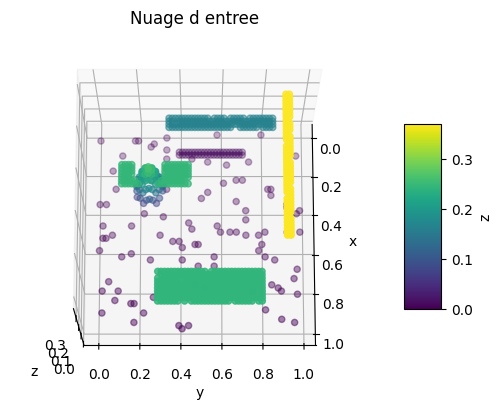

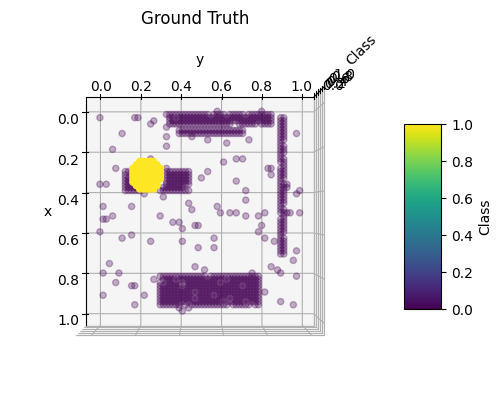

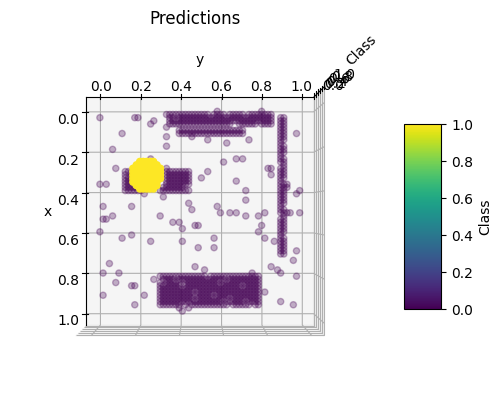

Sample 1


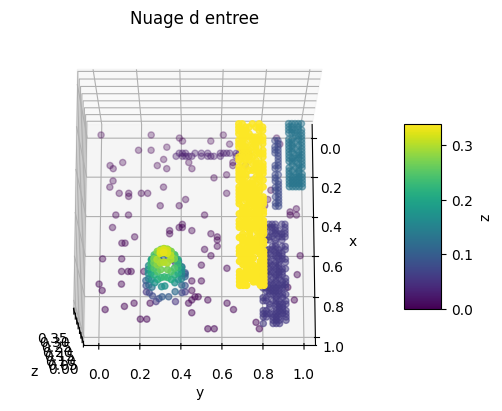

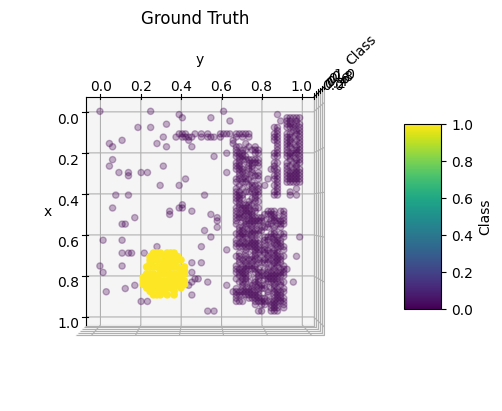

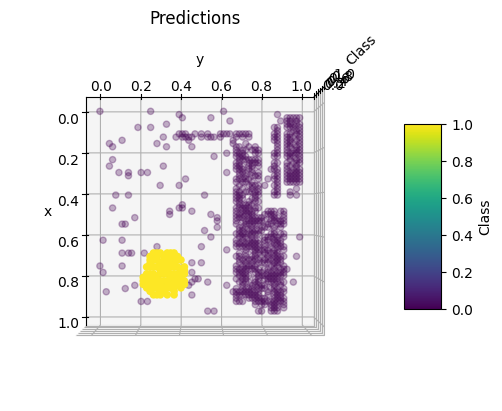

Sample 2


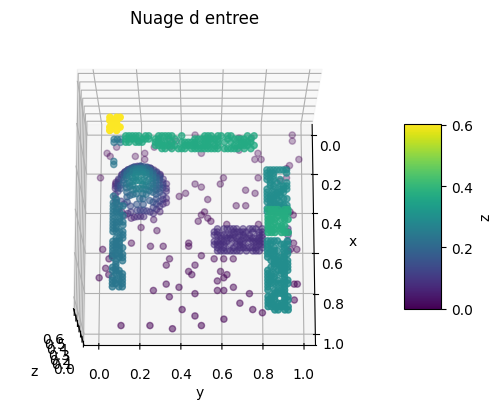

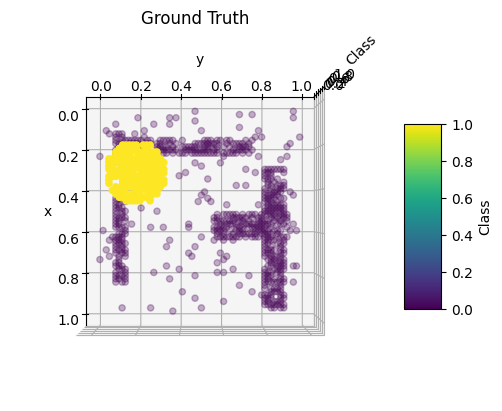

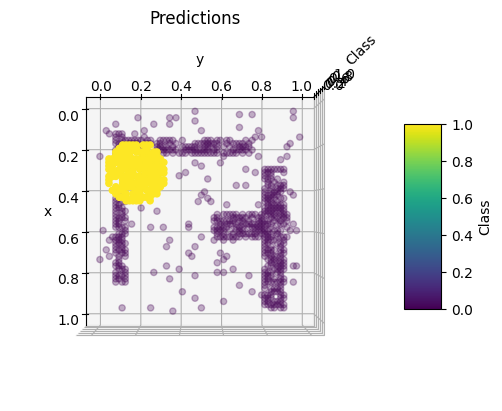

Sample 3


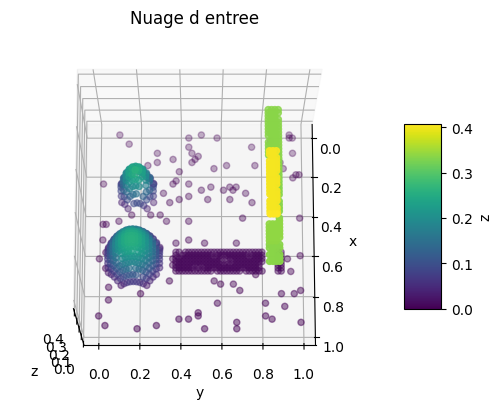

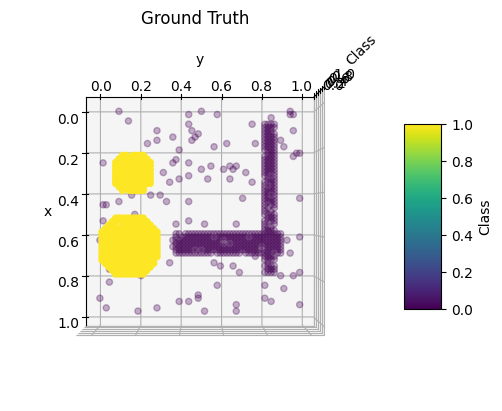

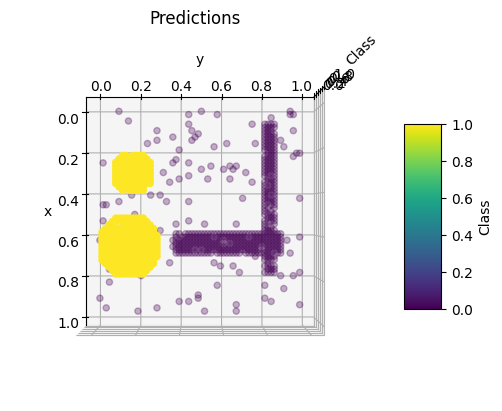

Sample 4


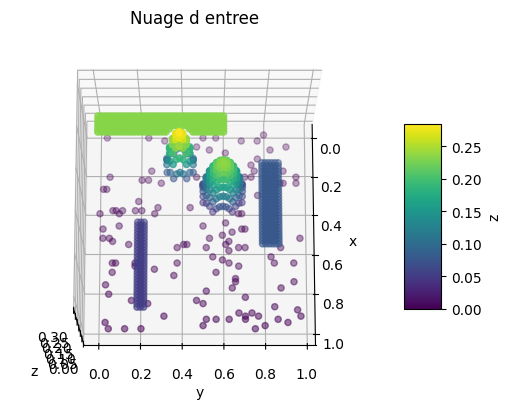

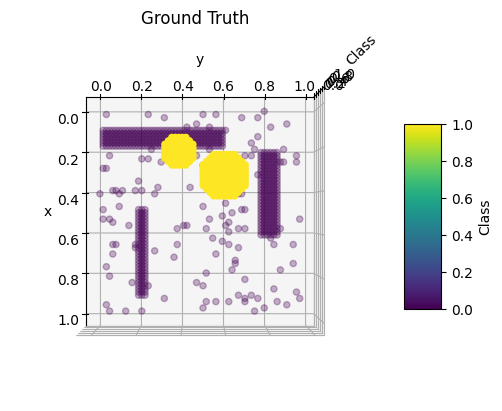

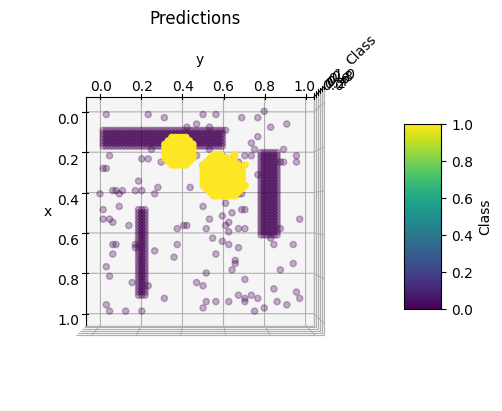

Sample 5


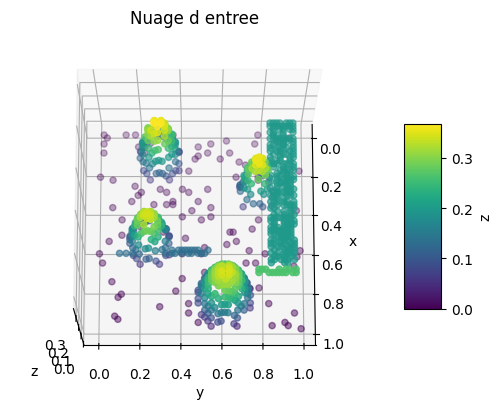

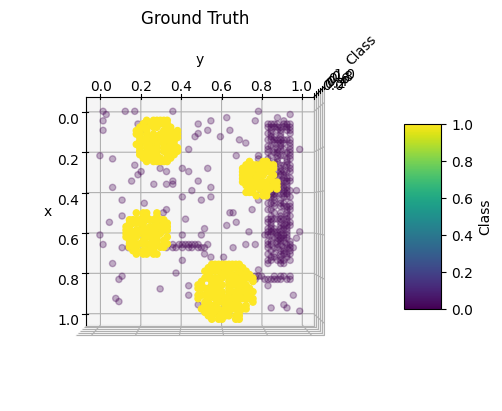

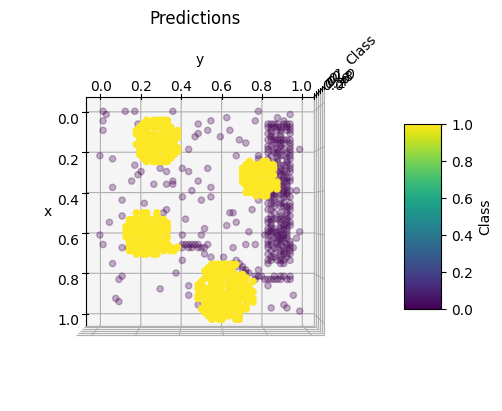

In [50]:
# Visualization: Display predictions for one batch of 6 samples
batch_size_vis = 6  # Only visualize a small batch
input_points_vis, _, target_points_vis = gen_pointcloud(batch_size_vis)

input_points_vis = input_points_vis.to(device)
target_points_vis = target_points_vis.to(device)

# Compute predictions for visualization batch
with torch.no_grad():
    proba_pred_list_vis, _, _ = pointnet(input_points_vis)
    pred_list_vis = proba_pred_list_vis.transpose(1, 2).max(1)[1].cpu()

# Plot results for 6 samples
for i in range(batch_size_vis):
    print(f"Sample {i}")

    # Plot input point cloud
    plot_triplets(input_points_vis[i].transpose(0, 1).cpu(), elev=75, azim=0)

    # Plot ground truth segmentation labels
    plot_triplets(target_points_vis[i].transpose(0, 1).cpu(),
                  title='Ground Truth',
                  cbar_label='Class')

    # Plot predicted segmentation labels

    plot_triplets(torch.cat([target_points_vis[i,:2].cpu(), pred_list_vis[i].unsqueeze(0).cpu()], dim=0).transpose(0, 1).cpu(),
                  title='Predictions',
                  cbar_label='Class')


In [45]:
pred_list_vis[i].cpu().cpu().shape

torch.Size([800])

tensor([[0.6875, 0.7500, 0.4375,  ..., 0.4375, 0.2188, 0.2656],
        [0.3125, 0.1719, 0.2500,  ..., 0.5000, 0.7500, 0.1406],
        [1.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [31]:
target_points.shape

torch.Size([64, 3, 800])

In [ ]:
input_points, target_list , target_points = gen_pointcloud(6)

# Il faut construire les prédictions.
proba_pred_list, _, _ = pointnet2.cuda()(input_points.to(device))
pred_list = proba_pred_list.transpose(1,2).max(1)[1].cpu()

# Accuracy:
...
# Tracé

for i in range(6):
  print(i)
  plot_triplets(input_points[i].transpose(0,1), elev=75, azim=0)
  plot_triplets(target_points[i].transpose(0,1),
                title='Cibles',
                cbar_label='classe')
  plot_triplets(...,
                title='Predictions',
                cbar_label='classe')

  batch_size = 6


